#Dados de opinião de filmes do IMDB

base Kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr

In [13]:
!pip install pyspark

In [14]:
from pyspark.sql import SparkSession

In [15]:
spark = SparkSession.builder\
                    .master('local[*]')\
                    .appName('analise_nlp')\
                    .getOrCreate()

In [16]:
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

In [17]:
dados.show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

#Explorando os Dados


In [20]:
# qtd de linhas

dados.count()


49459

In [22]:
# qtd de colunas

len(dados.columns)

4

In [23]:
#tipos

dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [28]:
# filtro

print('Negativo')
dados.filter(dados.id == 190).select('text_pt').show(truncate=False)
print('Positivo')
dados.filter(dados.id == 12427).select('text_pt').show(truncate=False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [29]:
# agrupar por sentimento

dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



#Limpando e Processando os Dados

In [31]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



**WorldCloud**

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [39]:
amostra = dados.select('text_pt').sample(fraction = 0.1, seed=101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [45]:
wordcloud = WordCloud(
    collocations=False,
    background_color='white',
    prefer_horizontal=1,
    width=1000,
    height=600
).generate(str(tudo))

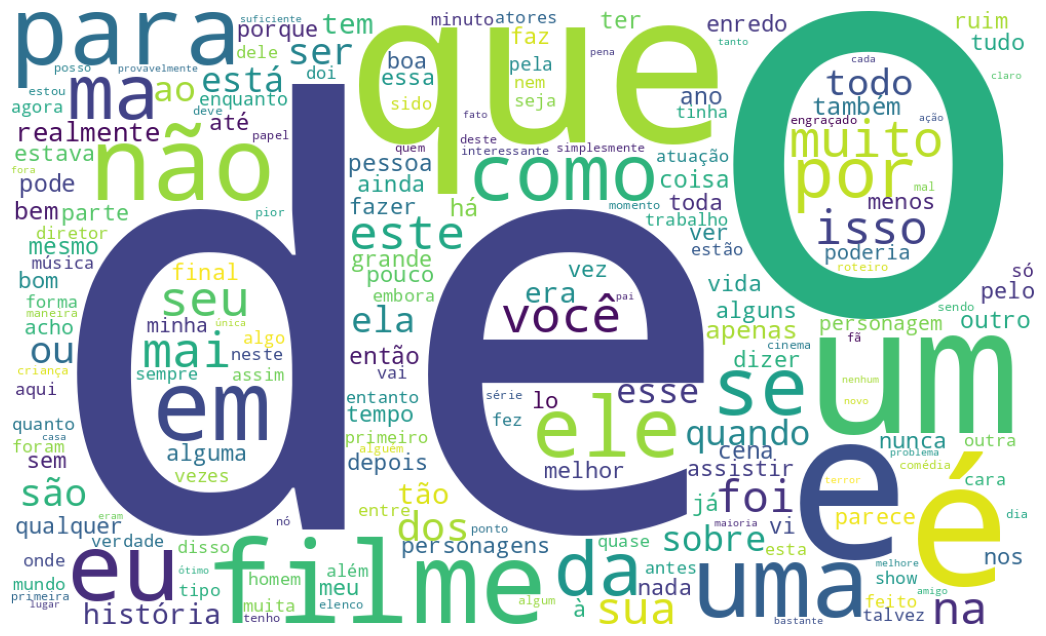

In [46]:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Limpeza de caracteres especiais**

In [49]:
# caracteres especiais do módulo string

import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [51]:
# amostra teste!!

amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",)
        ], ["textos"])


In [53]:
import pyspark.sql.functions as f

In [55]:
#retirando os carateres especiais da amostra

amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
amostra.show(truncate = False)


+------------------------------------------+------------------------------+
|textos                                    |texto_regex                   |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                            |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [56]:
#retirando os espaços em branco
amostra = amostra.withColumn('texto_limpo', f.trim(amostra.texto_regex))
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regex                   |texto_limpo                  |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]

In [57]:
#retirando os carateres especiais dos dados

dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./;:<=>?@^_`´{|}~\\\\]", ""))
dados.limit(2).show(truncate = False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
#retirando os espaços em branco
dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Tokenização: divisão em tokens**

In [63]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')


In [64]:
#transformando os dados em tokens

tokenizado = tokenizer.transform(dados)

In [66]:
tokenizado.select('texto_limpo', 'tokens').limit(2).show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
+--------------------+--------------------+



In [73]:
#quantidade de tokens criados

from pyspark.sql.types import IntegerType
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

In [74]:
tokenizado.select('texto_limpo', 'tokens')\
          .withColumn('Freq_tokens', countTokens(f.col('tokens')))\
          .show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

**StopWords: remoção de ruídos**

In [76]:
#exemplo

data = [(1, 'Spark é ótimo e NLP com Spark é fácil'),
                (0, 'Spark MLlib não ajuda muito'),
                (1, 'O MLlib do Spark ajuda e é fácil')]

colNames =['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)


In [78]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
stop_A

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [79]:
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")


In [81]:
stop_B

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera',
 'es

In [82]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol= "tokens")
tokenized = tokenizer.transform(df)


In [83]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final")


In [84]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_A)

df = remover.transform(tokenized)

df.show(truncate = False)


+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [85]:
remover = StopWordsRemover(inputCol = "tokens", outputCol= "texto_final", stopWords = stop_B)

df = remover.transform(tokenized)

df.show(truncate = False)


+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [87]:
df.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()


+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[spark, é, ótimo,...|[spark, é, ótimo,...|          9|                7|
|[spark, mllib, nã...|[spark, mllib, aj...|          5|                3|
|[o, mllib, do, sp...|[mllib, spark, aj...|          8|                5|
+--------------------+--------------------+-----------+-----------------+



In [88]:
#fim do exemplo

In [90]:
#retirando stopwords dos depoimentos

remover = StopWordsRemover(inputCol= 'tokens', outputCol='texto_final')
feature_data = remover.transform(tokenizado)

In [92]:
feature_data.limit(10).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [91]:
#contagem de palavras antes e depois do stopwords
feature_data.select('tokens', 'texto_final')\
            .withColumn('Freq_tokens', countTokens(f.col('tokens')))\
            .withColumn('Freq_tokens_limpos', countTokens(f.col('texto_final')))\
            .show()


+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
|[a, funny, thing,...|[funny, thing, ha...|        115|                52|
|[this, german, ho...|[german, horror, ...|        156|                74|
|[being, a, longti...|[longtime, fan, j...|        136|                73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|                75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|                99|
|[cage, plays, a, ...|[ca

**Vetorização: Bag of Words**

In [93]:
#retomando o exemplo

from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol='texto_final', outputCol='CountVec')
model = cv.fit(df)
df = model.transform(df)

In [94]:
#quais são as palavras

model.vocabulary

['spark', 'é', 'mllib', 'fácil', 'ajuda', 'nlp', 'ótimo']

In [95]:
df.select('texto_final', 'CountVec').show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,3,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



**CountVector**

In [103]:
#CountVectorizer

from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol='texto_final', outputCol='CountVec')
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)



In [102]:
#ordem das palavras

model.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'first',
 'dont',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'say',
 'still',
 'end',
 'scene',
 'scenes',
 'man',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'thing',
 'actors',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'director',
 'quite',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'thought',
 'enough',
 'give',
 'world',
 'big',
 'horror',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'always',
 'long',
 'with

In [104]:
countVectorizer_features.select('texto_final', 'CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



**HasingTF: alternativa para o CountVector**

In [105]:
from pyspark.ml.feature import HashingTF

In [106]:
hashingTF = HashingTF(inputCol='texto_final', outputCol='hashingTF')
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [107]:
HTFfeaturizedData.select('texto_final', 'hashingTF').limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



**TF-IDF: estabelecendo pesos**

In [108]:
from pyspark.ml.feature import IDF

In [111]:
idf = IDF(inputCol='hashingTF', outputCol='features')
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [114]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Codificando: variável resposta**

In [115]:
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [116]:
# codificando a variavel resposta

from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol='sentiment', outputCol='label')
dados = stringindexer.fit(dados).transform(dados)

In [117]:
# quem é 0 e quem é 1?

dados.groupBy('sentiment', 'label').count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



**Pipeline: Transformação dos dados**

In [118]:
#Unindo as transformações

from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final')
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol='HTF', numFeatures=1000)
tfidf = IDF(inputCol='HTF', outputCol='features')

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfidf])

In [120]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [121]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   